# Algorytmy Macierzowe
## Zadanie 1: Mnożenie macierzy
## Autorzy: Jan Izydorczyk, Aleksander Wójtowicz

# Cel zadania
Celem zadania było wykonanie eksperymentu polegającego na przetestowaniu różnych sposobów mnożenia macierzy. Sposoby te są wariacjami na tradycyjnego mnożenia macierzy, jednakże różnią się one kolejnością pętli podczas mnożenia. Implikują one różne sposoby wgrywania danych z pamięci operacyjnej do pamięci podręcznej procesora (różne wycinki danych) oraz ich przetwarzania (odpowiednia struktura danych może pozwolić na wykorzystanie operacji wektorowych). Dodatkowo przetestowaliśmy mnożenie macierzy z użyciem podziału na bloki.

# Wybór macierzy
Jako macierz testową wybraliśmy blokową macierz powstałą z macierzy typu rIGA, wygenerowanej za pomocą dołączonego skryptu w zestawie zadania (używjąc funkcji `massmatrix`, z parametrami `2, 4, 2, 2`). Macierz bazowa ta ma rozmiar $49 \times 49$, macierz wynikowa powstała z zwielokrotnienia tej macierzy wzdłuż każdej osi $2^5$ razy, co ostatnie daje macierz o wymiarach $49 \cdot 2^5 \times 49 \cdot 2^5$.

# Program do mnożenia
Moduł do mnożenia macierzy został napisany w języku C oraz skompilowany kompilatorem `gcc` z użyciem flag `-O3 -fno-loop-interchange -march=native`. Pierwsza opcja włącza zaawansowane optymalizacje kodu (m. in. wektoryzację operacji wykonywanych w pętlach), druga opcja wyłącza możliwość zamiany kolejności iteracji w zagnieżdzonych pętlach (ponieważ chcemy tą własność kontrolować sami), trzecia opcja jest wskazówką dla kompilatora jakich zestawów instrukcji można użyć w zoptymalizowanym programie - architektura `native` oznacza tą, na której uruchamiany jest kompilator. Program wczytuje i zapisuje macierze z plików, dodatkowo na standardowym wyjściu zwraca czas mnożenia. Program zawiera 12 różnych implementacji funkcji mnożącej (6 kolejności iterowania po macierzach * wersja domyślna/blokowa). Kod źródłowy programu można znaleźć w pliku `prog.c`.

Dodatkowo została przygotowana minibiblioteka `iface.py`, która jest interfejsem do wyżej opisanego programu dla Pythona i biblioteki NumPy.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iface import calc

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
def load_base_matrix():  
    return np.genfromtxt('riga49.csv', delimiter=',')
        
def generate_matrix(q):
    t = load_base_matrix()
    return np.block([[t] * q] * q)

In [3]:
q = 2 ** 5
A = generate_matrix(q)
B = A
_, AxB = calc(A, B, 'pij')

# Wizualizacja macierzy

Poniższy kod wyrysowuje schemat wartości własnych wyżej wymienionych macierzy.

Text(0.5, 1.0, 'Macierz $A \\times B$')

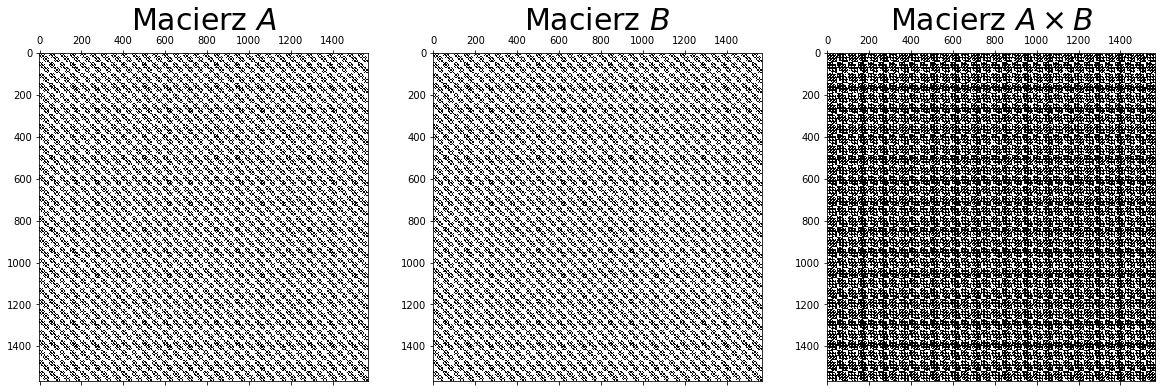

In [4]:
fig, axs = plt.subplots(4, 1, figsize = (20, 20))
axs[0].spy(T)
axs[0].set_title('Macierz bazowa', fontsize=30)
axs[1].spy(A)
axs[1].set_title('Macierz $A$', fontsize=30)
axs[2].spy(B)
axs[2].set_title('Macierz $B$', fontsize=30)
axs[3].spy(AxB)
axs[3].set_title('Macierz $A \\times B$', fontsize=30)

# Testy kolejności pętli

Testy zostały wykonane na wybranej macierzy, na każdej możliwej kolejności pętli. W tym miejscu wykorzystujemy algorytm domyślny, nie iterujący po macierzach w sposób blokowy.

In [5]:
orders = [
    'ijp',
    'ipj',
    'jip',
    'jpi',
    'pij',
    'pji'
]

def measure_time(A, B, orders=orders, tries=1):
    res_df = []
    for order in orders:
        sum_time = 0
        for _ in range(tries):
            time, _ = calc(A, B, order)
            sum_time = sum_time + time
        avg_time = sum_time / tries
        res_df.append([order, avg_time])
        print(f'{order}: {avg_time}')
    return pd.DataFrame(res_df, columns=('order', 'avg_time'))

In [6]:
res_df = measure_time(A, B, tries=10)
res_df.rename(columns={'order': 'Order', 'avg_time': 'Average time [s]'})

ijp: 13.033518
ipj: 1.59753
jip: 9.657723
jpi: 36.806437
pij: 2.148063
pji: 34.47952


,Order,Average time [s]
0,ijp,13.033518
1,ipj,1.597530
2,jip,9.657723
3,jpi,36.806437
4,pij,2.148063
5,pji,34.479520


## Wnioski
Najszybsze okazały się kolejności `ipj` oraz `pij`, po nich `ijp`, `jip`, najwolniejsze były `jpi` i `pji`.



In [7]:
matrix_size = '$49 \\cdot 2^{5} \\times 49 \\cdot 2^{5}$'

<BarContainer object of 6 artists>

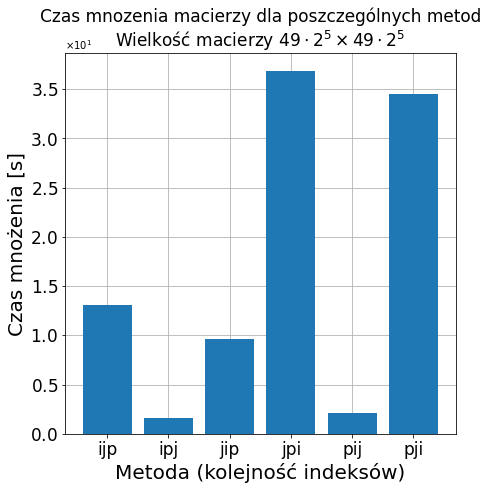

In [8]:
xs, ys = res_df['order'], res_df['avg_time']
fig = plt.figure(figsize = (7, 7))
plt.title(f'Czas mnozenia macierzy dla poszczególnych metod\nWielkość macierzy {matrix_size}', fontsize = 17)
plt.xlabel('Metoda (kolejność indeksów)', fontsize = 20)
plt.ylabel('Czas mnożenia [s]', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize = 17)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
plt.grid(zorder=-1)
plt.bar(xs, ys, zorder=3)

# Testy mnożenia blokowego
Dla zadanej macierzy została wybrana kolejność pętli `ipj`.

## Testy dla kolejnych potęg liczby 2

Początkowo zostały przetestowane liczby bloków 1, 2, 4, 8, 16, ..., $\frac{n}{2}$, w celu znalezienia wstępnej optymalnej liczby bloków. 

In [9]:
def measure_blocks(A, B, order, ns_blocks, tries=1):
    import math
    n = len(A)
    xs, avg_times = [], []
    for n_blocks in ns_blocks:
        sum_time = 0
        for _ in range(tries):
            block_size = math.ceil(n / n_blocks)
            if n_blocks == 1:
                block_size = 0
            time, _ = calc(A, B, order, block_size)
            sum_time = sum_time + time
        avg_time = sum_time / tries
        avg_times.append(avg_time)
    return ns_blocks, avg_times

In [7]:
# def measure_blocks_2pow(A, B, order, tries=1):
#     import math
#     n = len(A)
#     xs, ys = [], []
#     k = 1
#     while k < n:
#         sum_time = 0
#         for _ in range(tries):
#             block_size = math.ceil(n / k)
#             if k == 1:
#                 block_size = 0
#             time, _ = calc(A, B, order, block_size)
#             sum_time = sum_time + time
#         avg_time = sum_time / tries
#         xs.append(k)
#         ys.append(avg_time)
#         k *= 2
#     return xs, ys
def measure_blocks_2pow(A, B, order, tries=1):
    ns_blocks = np.logspace(0, 10, 10 - 0 + 1, base=2).astype(int)
    return measure_blocks(A, B, order, ns_blocks, tries)

In [10]:
xs, ys = measure_blocks_2pow(A, B, 'ipj', tries=10)

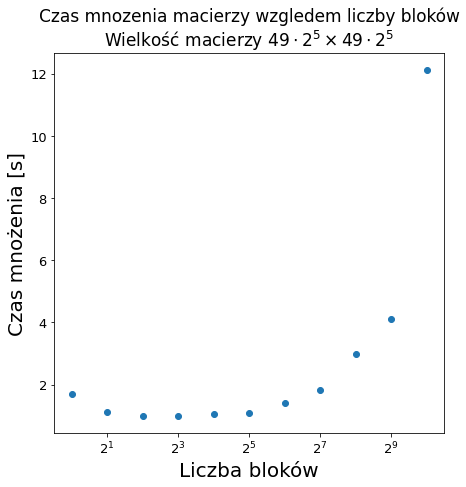

In [11]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Czas mnozenia macierzy wzgledem liczby bloków\nWielkość macierzy {matrix_size}', fontsize = 17)
plt.xlabel('Liczba bloków', fontsize = 20)
plt.ylabel('Czas mnożenia [s]', fontsize = 20)
plt.xscale('log', base=2)
plt.tick_params(axis='both', which='major', labelsize = 13)
plt.scatter(xs, ys)

## Wnioski
Wstępne testy wykazały, że optymalny rozmiar bloku jest pomiędzy $2$, a $8$. 

## Testy dla liczby bloków pomiędzy 2 a 8

In [12]:
def measure_blocks_lin(A, B, order, tries=1):
    ns_blocks = np.arange(2, 16).astype(int)
    return measure_blocks(A, B, order, ns_blocks, tries)
# def measure_blocks_lin(A, B, order, tries=1):
#     import math
#     n = len(A)
#     xs, ys = [], []
#     k = 1
#     for k in range(2, 16):
#         sum_time = 0
#         for _ in range(tries):
#             block_size = math.ceil(n / k)
#             time, _ = calc(A, B, order, block_size)
#             sum_time = sum_time + time
#         avg_time = sum_time / tries
#         xs.append(k)
#         ys.append(avg_time)
#         k *= 2
#     return xs, ys

In [15]:
xs, ys = measure_blocks_lin(A, B, 'ipj', tries=10)

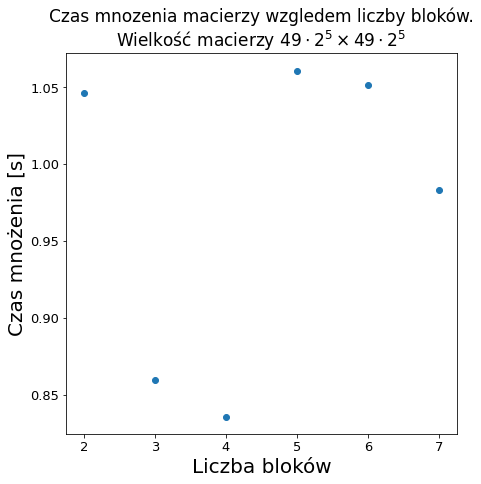

In [16]:
fig = plt.figure(figsize = (7, 7))
plt.title(f'Czas mnozenia macierzy wzgledem liczby bloków.\nWielkość macierzy {matrix_size}', fontsize = 17)
plt.xlabel('Liczba bloków', fontsize = 20)
plt.ylabel('Czas mnożenia [s]', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize = 13)
plt.scatter(xs, ys)

## Wnioski
Dla danych wykorzystanych w tym ćwiczeniu optymalną ilością podziałów na bloki okazała się wartość $4$, co daje nam $16$ bloków. Uzyskaliśmy czas ok. 0,8s, co daje dwukrotne przyśpieszenie względem algorytmu bez podziału na bloki.

# Podsumowanie

Najbadziej wydajną kolejnością pętli podczas mnożenia macierzy okazały się kolejności `ipj` i `pij`, odstając znacząco od reszty permutacji pętli. Dla wybranej metody `ipj` zostały wykonane testy liczby podziałów bloków, dla których mnożenie jest jeszcze szybsze, udało się ustalić, że liczba podziałów wzdłuż każdej osi wynosi 4, tj. 16 bloków.

Niezależnie od metody, każde mnożenie wymagalo $2 \cdot m \cdot n \cdot k = 2 \cdot n^3 \cdot q^3$ operacji, gdzie $n=49$, $q=2^5$ (należy zauważyć, że mnożenie blokowe jedynie zmienia kolejność ładowania danych do pamięci, natomiast nie zmieni liczby wykonywanych operacji), co daje ostatecznie $7,710,244,864$ operacji zmiennoprzecinkowych. Tą liczbę można by zmniejszyć, jeśli zdecydowalibyśmy się na kolejność iteracji `ijp` - w takim wypadku wiemy, że każde wykonanie wewnętrznej pętli (wzdłuż `p`) będzie dokonywać zapisów do zawsze tej samej, jednej komórki macierzy $(i,j)$. Wtedy pierwsza iteracja pętli `p` może zrezygnować z operacji dodawania na rzecz przypisania wartości. Jest to jednakże zysk znacznie mniejszy, niż wynikający z iterowania po macierzy w przyjazny dla cache procesora sposób.